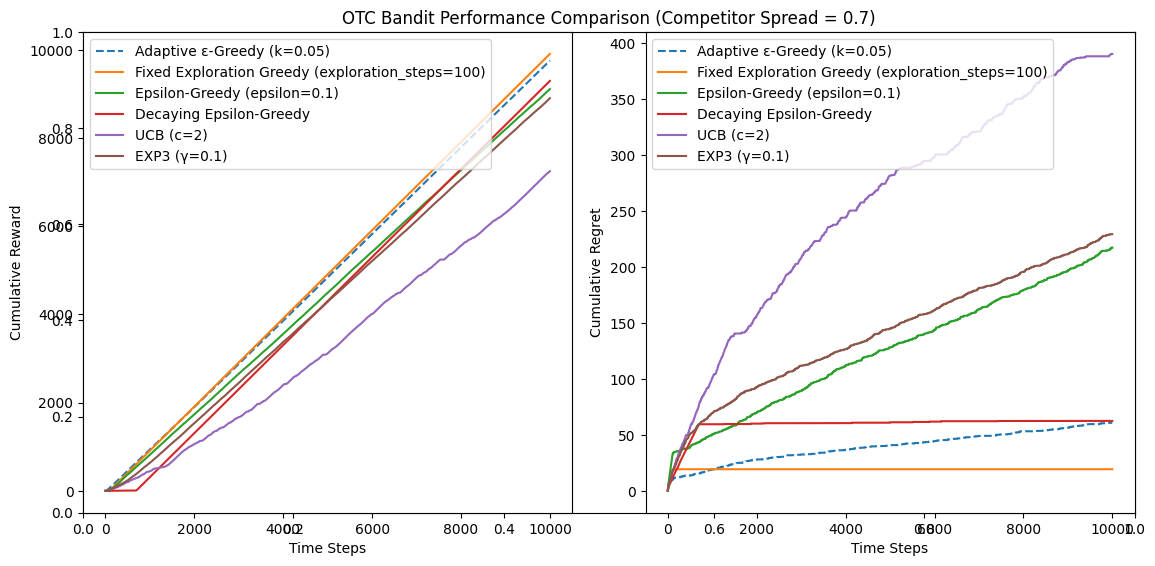

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

"""
Multi-Armed Bandit Algorithms in OTC (Order-to-Cover) Market Environment
This code compares various bandit algorithms in a simulated financial market scenario
where agents compete through spread selection.
"""

# ==========================
# Setting Evironment
# ==========================
class OTCEnvironment:
    """
    Simulates an Order-to-Cover market environment with spread-based execution probabilities
    
    Parameters:
    - spreads: List of available spreads (arms)
    - competitor_spread: Fixed spread used by market competitor
    - alpha: Market competitiveness parameter (higher = more competitive)
    """
    def __init__(self, spreads, competitor_spread, alpha=0.3):
        self.spreads = np.array(spreads)
        self.competitor_spread = competitor_spread
        self.alpha = alpha # Controls steepness of execution probability curve
        
    def get_execution_prob(self, s):
        """
        Calculate execution probability for a given spread using logistic function
        - Lower spreads (< competitor) have exponentially decreasing advantage
        - Higher spreads (>= competitor) have reduced execution probability
        """
        if s < self.competitor_spread:
            # Favorable spread: probability decreases with distance from competitor
            return 1 / (1 + np.exp(self.alpha * (self.competitor_spread - s)))
        else:
            # Unfavorable spread: additional penalty for being worse than competitor
            return 1 / (1 + np.exp(self.alpha * (s - self.competitor_spread + 0.1)))
        
    def pull_arm(self, arm):
        """Simulate arm pull with probabilistic reward (spread * execution probability)"""
        s = self.spreads[arm]
        prob = self.get_execution_prob(s)
        win = np.random.binomial(1, prob)
        return win * s

# ==========================
# New Adaptive Epsilon-Greedy
# ==========================
class AdaptiveEpsilonGreedy:
    """
    Epsilon-Greedy variant with UCB-inspired adaptive exploration rate
    Exploration probability ε_t = min(1, k*sqrt(log(t)/n_min))
    where n_min is minimum pull count across arms
    
    Parameters:
    - num_arms: Number of arms/spreads
    - k: Exploration scaling factor
    """
    def __init__(self, num_arms, k):
        self.num_arms = num_arms
        self.k = k
        self.counts = np.zeros(num_arms)  # Pull counts per arm
        self.values = np.zeros(num_arms)  # Empirical reward averages
        self.t = 1  # Time step counter
        
    def select_arm(self):
        """Select arm using ε-greedy strategy with adaptive exploration rate"""
        if np.random.random() < self._calculate_epsilon():
            return np.random.randint(self.num_arms)  # Uniform exploration
        else:
            return np.argmax(self.values)  # Greedy exploitation
            
    def _calculate_epsilon(self):
        """Calculate adaptive exploration rate using UCB-style uncertainty"""
        n_min = np.min(self.counts) if np.all(self.counts > 0) else 1
        return min(1, self.k * np.sqrt(np.log(self.t) / n_min))
        
    def update(self, arm, reward):
        """Update arm estimates using incremental average"""
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1  # Increment time step

# ==========================
# Fixed Exploration Then Exploitation Greedy
# ==========================
class FixedExplorationThenGreedy:
    def __init__(self, num_arms, exploration_steps):
        self.num_arms = num_arms
        self.exploration_steps = exploration_steps
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        if self.t <= self.exploration_steps:
            return (self.t - 1) % self.num_arms
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Epsilon-Greedy
# ==========================
class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

# ==========================
# Epsilon-Greedy with Decaying Exploration
# ==========================
class EpsilonGreedyDecaying:
    def __init__(self, num_arms, epsilon_schedule):
        self.num_arms = num_arms
        self.epsilon_schedule = epsilon_schedule
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        epsilon = self.epsilon_schedule(self.t)
        if np.random.rand() < epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# UCB
# ==========================
class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1
        
    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)
        
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# EXP3
# ==========================
class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1
        
    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)
        
    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.t += 1

# ==========================
# Experiment Runner
# ==========================
def run_experiment(bandit_class, bandit_params, env, num_steps):
    """
    Run bandit algorithm experiment and track performance metrics
    
    Parameters:
    - bandit_class: Algorithm class to test
    - bandit_params: Dictionary of algorithm parameters
    - env: OTCEvironment instance
    - num_steps: Number of iterations
    
    Returns:
    - cum_rewards: Cumulative correct arm selections
    - cum_regret: Cumulative regret compared to optimal
    """
    bandit = bandit_class(**bandit_params)
    rewards = []
    regrets = []
    
    # Precompute optimal arm once
    expected_rewards = [s * env.get_execution_prob(s) for s in env.spreads]
    optimal_arm = np.argmax(expected_rewards)
    optimal_reward = expected_rewards[optimal_arm]
    
    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        
        # Calculate instantaneous regret
        current_expected = env.spreads[arm] * env.get_execution_prob(env.spreads[arm])
        regret = optimal_reward - current_expected
        regrets.append(regret)
        rewards.append(1 if arm == optimal_arm else 0)
    
    return np.cumsum(rewards), np.cumsum(regrets)

# ==========================
# Experiment Configuration
# ==========================

spreads = [0.1, 0.3, 0.5, 0.7, 0.9] # Available spreads
num_arms = len(spreads) # Number of arms
competitor_spread = 0.7  # Competitor's fixed spread
alpha = 0.4 # High alpha means high competitiveness (steep execution prob curve)
env = OTCEnvironment(
    spreads, 
    competitor_spread=competitor_spread,
    alpha=alpha
)
num_steps = 10000  # Simulation length 

# ==========================
# Algorithm Parameters
# ==========================

k = 0.05  # Adaptive ε-Greedy exploration scaling
exploration_steps = 100  # Fixed exploration phase length
epsilon = 0.1  # Standard ε-Greedy exploration rate
c = 2  # UCB exploration weight
gamma = 0.1  # EXP3 exploration parameter
def epsilon_schedule(t): # ε decay schedule for Decaying ε-Greedy
    #return 1 / (t + 1)
    #return 1 / np.sqrt(t + 1)
    return np.log(t+1)/(t+1)

# ==========================
# Running Experiments
# ==========================

'''
# Test multiple k values for AdaptiveEpsilonGreedy

k_values = np.linspace(0.05, 1, 5)  # [0.1, 0.325, 0.55, 0.775, 1.0]
aeg_results = []

for k in k_values:
    reward, regret = run_experiment(AdaptiveEpsilonGreedy, 
                                  {'num_arms': len(spreads), 'k': k}, 
                                  env, num_steps)
    aeg_results.append((k, reward, regret))
'''
# Adaptive ε-Greedy
adaptive_epsilon_greedy_reward, adaptive_epsilon_greedy_regret = run_experiment(AdaptiveEpsilonGreedy, {'num_arms': num_arms, 'k': k}, env, num_steps)
# Fixed exploration Greedy
fixed_exploration_greedy_reward, fixed_exploration_greedy_regret = run_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': exploration_steps}, env, num_steps)
# ε-Greedy
epsilon_greedy_reward, epsilon_greedy_regret = run_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': epsilon}, env, num_steps)
#Decaying ε-Greedy
decaying_epsilon_greedy_reward, decaying_epsilon_greedy_regret = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env, num_steps)
# UCB
ucb_reward, ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': c}, env, num_steps)
# EXP3
exp3_reward, exp3_regret = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': gamma}, env, num_steps)

# ==========================
# Visualization
# ==========================

plt.figure(figsize=(12, 6))
plt.title(f"OTC Bandit Performance Comparison (Competitor Spread = {competitor_spread})")

# Reward Plot
plt.subplot(1, 2, 1)
'''
# Plot AEG variants

for k, reward, _ in aeg_results:
    plt.plot(reward, label=f'Adaptive ε-Greedy (k={k:.2f})', alpha=0.7, linestyle='--')
'''
plt.plot(adaptive_epsilon_greedy_reward, label=f'Adaptive ε-Greedy (k={k})', linestyle='--')
plt.plot(fixed_exploration_greedy_reward, label=f'Fixed Exploration Greedy (exploration_steps={exploration_steps})')
plt.plot(epsilon_greedy_reward, label=f'Epsilon-Greedy (epsilon={epsilon})')
plt.plot(decaying_epsilon_greedy_reward, label='Decaying Epsilon-Greedy')
plt.plot(ucb_reward, label=f'UCB (c={c})')
plt.plot(exp3_reward, label=f'EXP3 (γ={gamma})')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.legend()


# Regret Plot
plt.subplot(1, 2, 2)
'''
# Plot AEG variants

for k, _, regret in aeg_results:
    plt.plot(regret, label=f'Adaptive ε-Greedy (k={k:.2f})', alpha=0.7, linestyle='--')
'''
plt.plot(adaptive_epsilon_greedy_regret, label=f'Adaptive ε-Greedy (k={k})', linestyle='--')
plt.plot(fixed_exploration_greedy_regret, label=f'Fixed Exploration Greedy (exploration_steps={exploration_steps})')
plt.plot(epsilon_greedy_regret, label=f'Epsilon-Greedy (epsilon={epsilon})')
plt.plot(decaying_epsilon_greedy_regret, label='Decaying Epsilon-Greedy')
plt.plot(ucb_regret, label=f'UCB (c={c})')
plt.plot(exp3_regret, label=f'EXP3 (γ={gamma})')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.tight_layout()
plt.show()